In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [6]:
chess_evals = pd.read_csv("../Datasets/chessData.csv").head(int(5e4))
random_evals = pd.read_csv("../Datasets/random_evals.csv").head(int(5e4))
tactic_evals = pd.read_csv("../Datasets/tactic_evals.csv").head(int(5e4))

In [7]:
raw_data = pd.concat([chess_evals, random_evals, tactic_evals], join="inner")

In [8]:
piece_map = ["P", "N", "B", "R", "Q", "K"]
piece_map = {i: piece_map.index(i) for i in piece_map}

def parse_row(row):
    ret = []
    for i in row:
        sq = [0] * len(piece_map) * 2
        if i in piece_map:
            sq[piece_map[i]] = 1
        elif i.upper() in piece_map:
            sq[piece_map[i.upper()] + len(piece_map)] = 1
        n = int(i) if i in "1234567890" else 1
        for i in range(n):
            ret.append(sq)
    return ret

def parse_fen(fen):
    pos, move, *_ = fen.split(" ")
    if move == "b":
        pos = "".join(reversed(pos.swapcase()))
    pos = [parse_row(i) for i in pos.split("/")]
    pos = np.array(pos)
    return (pos, move == "b") # arr, flip

parse_fen("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")[0].shape

(8, 8, 12)

In [9]:
def parse_eval(ev):
    if ev[0] == "#":
        ev = ev[1:] + "000"
    ev = eval(ev)
    if ev > 150:
        return 0
    if ev < -150:
        return 2
    return 1

In [ ]:
def preprocess(row):
    row[0], flip = parse_fen(row[0])
    row[1] = parse_eval(row[1])
    if flip:
        row[1] = 2 - row[1]
    row[1] = np.array([1 if i == row[1] else 0 for i in range(3)])
    return row

data = raw_data.head(int(1e5)).copy().apply(preprocess, axis=1)
data.columns = ["Position", "Evaluation"]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\762468161.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0], flip = parse_fen(row[0])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\762468161.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0], flip = parse_fen(row[0])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\762468161.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[1] = parse_eval(row[1])
C:\User

In [11]:
X, y = np.stack(data.Position, axis=0), np.stack(data.Evaluation, axis=0)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [12]:
c = np.array([0, 0, 0])
def f(x):
    global c
    c += x
data.Evaluation.apply(f)
c

array([38633, 48514, 12853])

In [13]:
model = Sequential([
    Conv2D(250, kernel_size=5, padding="same", activation="relu", input_shape=(8, 8, 12)),
    Conv2D(150, kernel_size=5, padding="same", activation="relu"),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax"),
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

c:\Users\ASUS\Desktop\stocksalmon\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=1000, callbacks=[EarlyStopping(monitor="val_categorical_accuracy", patience=5, restore_best_weights=True)])


Epoch 1/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 65s 26ms/step - categorical_accuracy: 0.7443 - loss: 0.5846 - val_categorical_accuracy: 0.8145 - val_loss: 0.4547
Epoch 2/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - categorical_accuracy: 0.8575 - loss: 0.3620 - val_categorical_accuracy: 0.8473 - val_loss: 0.3840
Epoch 3/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 69s 28ms/step - categorical_accuracy: 0.8936 - loss: 0.2689 - val_categorical_accuracy: 0.8544 - val_loss: 0.3751
Epoch 4/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - categorical_accuracy: 0.9161 - loss: 0.2148 - val_categorical_accuracy: 0.8638 - val_loss: 0.3687
Epoch 5/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - categorical_accuracy: 0.9297 - loss: 0.1788 - val_categorical_accuracy: 0.8699 - val_loss: 0.3869
Epoch 6/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 74s 30ms/step - categorical_accuracy: 0.9402 - loss: 0.1513 - val_categorical_accuracy: 0.8684 - val_loss: 0.4226
Epoch 7/1000
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms

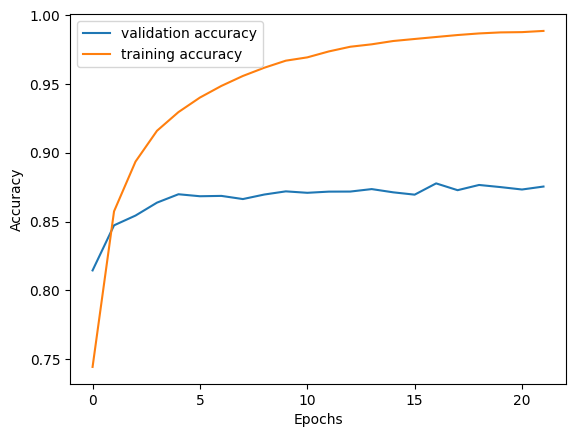

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_categorical_accuracy"], label="validation accuracy")
plt.plot(history.history["categorical_accuracy"], label="training accuracy")

plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

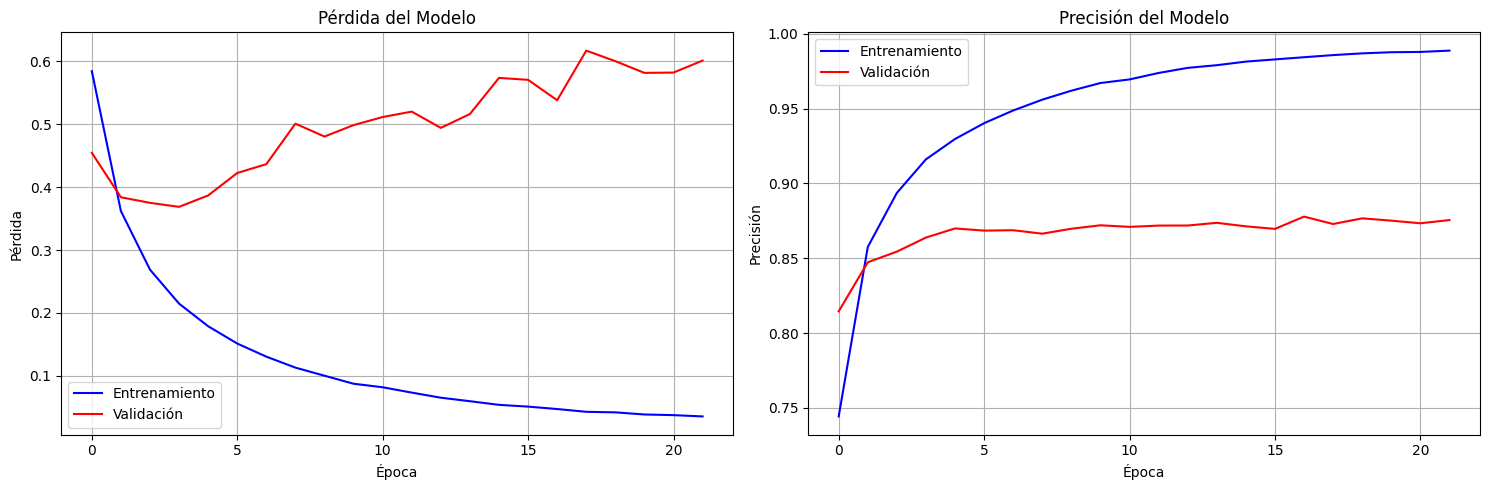

In [16]:
def plot_training_history(history):
    """
    Grafica métricas de entrenamiento vs validación.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pérdida
    ax1.plot(history.history['loss'], label='Entrenamiento', color='blue')
    ax1.plot(history.history['val_loss'], label='Validación', color='red')
    ax1.set_title('Pérdida del Modelo')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)
    
    # Precisión
    ax2.plot(history.history['categorical_accuracy'], label='Entrenamiento', color='blue')
    ax2.plot(history.history['val_categorical_accuracy'], label='Validación', color='red')
    ax2.set_title('Precisión del Modelo')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualizar entrenamiento
plot_training_history(history)